# Segmentation des clients d'une site de E-commerce
------------------
## 1. Analyse exploratoire

Ce notebook présente l'analyse exploratoire des données. Seules les données importantes sont présentées.


## Imports
Nous utiliserons les library standard de datascience : `numpy`, `pandas`, `sklearn`, `matplotlib`. 

In [48]:
import numpy as np
import pandas as pd 
from scipy.stats import randint, uniform, normaltest

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# sklearn preprocessing for dealing with categorical variables
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import *
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, DBSCAN
from sklearn.manifold import TSNE

from yellowbrick.cluster import KElbowVisualizer, silhouette_visualizer,SilhouetteVisualizer

import folium

import os

# Suppress warnings 
import warnings
warnings.filterwarnings('ignore')




pd.set_option('display.max_rows', 200)
pd.set_option('display.max_columns', 200)

In [49]:
def inspect_dupes(df, dedupe=False):
    '''
    Checks duplicates (rows), and gets rid of duplicates if dedupe arg set to 'True' 
    Arg: dataframe, dedupe (bool)
    '''
    num_of_dupe = len(df[df.duplicated()])

    if dedupe and num_of_dupe>0: 
        df.drop_duplicates(inplace=True)
        print(f'Number of duplicates found: {num_of_dupe}')
        return df

    else: 
        print(f'Number of duplicates found: {num_of_dupe}')
        return num_of_dupe
    
def iqr(df,drop=False):
   
    cols_to_keep = [col for col in df.columns if df[col].nunique() > 2]
    dataframe = df[cols_to_keep]
    
    iqr_analysis_list = []

    # Sélection des variables numériques
    numeric_variables = dataframe.select_dtypes(include=['number'])
    l_ind_outlier=[]
    
    for variable_name in numeric_variables.columns:
        # Calcul de l'analyse IQR pour chaque variable numérique
        variable_data = dataframe[variable_name]
        
        # Calcul des quartiles
        Q1 = variable_data.quantile(0.25)
        Q3 = variable_data.quantile(0.75)
        
        # Calcul de l'IQR (Interquartile Range)
        IQR = Q3 - Q1
        
        # Détermination des limites inférieure et supérieure pour détecter les valeurs aberrantes
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        # Exclusion des individus aberrants
        excluded_count = ((variable_data < lower_bound) | (variable_data > upper_bound)).sum()
        
        # Calcul du ratio d'exclusion
        total_count = len(variable_data)
        exclusion_ratio = excluded_count / total_count
        
        # Ajout des résultats dans une liste
        iqr_analysis_list.append({
            'Variable': variable_name,
            'Q1': Q1,
            'Q3': Q3,
            'IQR': IQR,
            'Lower Bound': lower_bound,
            'Upper Bound': upper_bound,
            'Excluded Count': excluded_count,
            'Exclusion Ratio': exclusion_ratio
        })

        # Filtrer les valeurs en dehors des bornes IQR
        l_ind_outlier += dataframe[(dataframe[variable_name] <= lower_bound) |
                                   (dataframe[variable_name] >= upper_bound)].index.to_list()

    l_ind_outlier=set(l_ind_outlier)
    print(len(l_ind_outlier))
    
    if drop == True :
        dataframe=dataframe.drop(l_ind_outlier,axis=0)
    # Création d'un dataframe à partir de la liste des résultats
    iqr_analysis_df = pd.DataFrame(iqr_analysis_list)
    display(iqr_analysis_df.sort_values(by='Exclusion Ratio',ascending=False))
    
    return dataframe    
    
    
 # Réduit le nombre de décimale
def format_value(x):
    try:
        return f"{x:.2f}"
    except:
        return str(x)
    
  # Explorations de base du df  
def desc(df):
    print( '************************************')  
    print( '      Descriptif du dataset')
    print( '************************************')  
    print(f'Le dataset est composé de {df.shape[0]} individus et {df.shape[1]} variables.')
    display(df.head())
    display(df.dtypes)
    display(df.describe())
    display(bilan_null(df).sort_values(by='Missing ratio',ascending = True))

  # Renvoie un df avec les Nunique et des infos sur les NaN      
def bilan_null(df):
    df_bilan=pd.concat([df.nunique(),
                        df.isnull().mean(),
                        df.isnull().sum(),
                        df.notnull().sum()],
                        axis=1,
                        keys=['Nunique','Missing ratio','Null count','Notnull count'])
    return df_bilan.sort_values(by='Missing ratio')

# Fonction pour encoder les variables catégorielles
def cat_enc(df) :

    le = LabelEncoder()
    le_count = 0

    # Iterate through the columns
    for col in df:
        if df[col].dtype == 'object':
            # If 2 or fewer unique categories
            if len(list(df[col].unique())) <= 2:
                # Train on the training data
                le.fit(df[col])
                # Transform both training and testing data
                df[col] = le.transform(df[col])
                # Keep track of how many columns were label encoded
                le_count += 1

    print('%d columns were label encoded.' % le_count)
    # one-hot encoding of categorical variables
    df = pd.get_dummies(df,dtype=int)

    print('Training Features shape: ', df.shape)
    
    return df
def plot_target_cat(df, cat):

        plt.figure(figsize=(10, 6))
        sns.countplot(x=cat, hue="TARGET", data=df)
        plt.title("Effectifs de {} par {}".format(cat, "TARGET"))
        plt.xlabel(cat)
        if max([len(str(i)) for i in df[cat].unique()]) > 15:
            plt.xticks(rotation=45)
        if max([len(str(i)) for i in df[cat].unique()]) > 20:
            plt.xticks(rotation=90)
        plt.ylabel("Effectifs")
        plt.legend(title="TARGET", loc='upper right')
        plt.show()
        raw_df.groupby(cat)["TARGET"].mean().plot(kind='bar')    
        plt.title("Moyenne de défaut de paiement")
        if max([len(str(i)) for i in df[cat].unique()]) < 15:
            plt.xticks(rotation=0)
        if max([len(str(i)) for i in df[cat].unique()]) > 15:
            plt.xticks(rotation=45)
        if max([len(str(i)) for i in df[cat].unique()]) > 20:
            plt.xticks(rotation=90)
        plt.show()

def plot_target_num(df, numerical_column):

    # Création des bins
    df['bins'] = pd.cut(df[numerical_column], bins=11,precision=0)
    # Calcul de la moyenne de la cible pour chaque bin
    mean_target = df.groupby('bins')["TARGET"].mean()

    plt.figure(figsize=(10, 6))
    sns.countplot(x=df['bins'], hue="TARGET", data=df)
    plt.title("Effectifs de {} par {}".format(numerical_column, "TARGET"))
    plt.xlabel(numerical_column)
    if max([len(str(i)) for i in df[numerical_column].unique()]) > 15:
        plt.xticks(rotation=45)
    if max([len(str(i)) for i in df[numerical_column].unique()]) > 20:
        plt.xticks(rotation=90)
    plt.ylabel("Effectifs")
    plt.legend(title="TARGET", loc='upper right')
    plt.show()    
        
    
    # Tracé du barplot
    plt.figure(figsize=(10, 6))
    mean_target.plot(kind='bar')
    plt.title("Moyenne de défaut de paiement")
    plt.xlabel(numerical_column)
    plt.ylabel(('%'))
    if max([len(str(i)) for i in df[numerical_column].unique()]) > 15:
        plt.xticks(rotation=45)
    if max([len(str(i)) for i in df[numerical_column].unique()]) > 20:
        plt.xticks(rotation=90)
    plt.show()        

def plot_variables(df):

    # Plot numerical variables
    numerical_cols = df.select_dtypes(include=['int', 'float']).columns
    for col in numerical_cols:
        plt.figure(figsize=(8, 6))
        sns.histplot(data=df[df[col].notnull()], x=col, kde=True)
        plt.title(f'{col} Distribution')
        plt.axvline(df[col].mean(), color='red', linestyle='dashed', linewidth=2, label='Mean')
        plt.axvline(df[col].median(), color='green', linestyle='dashed', linewidth=2, label='Median')

        # Calculate normality test p-value
        _, p_value = normaltest(df[col].dropna())

        # Determine if normally distributed and annotate plot
        if p_value < 0.05:
            plt.text(1, 0.8, f'p-value: {p_value:.4f}\nNot normally distributed', 
                     ha='right', va='top', transform=plt.gca().transAxes, 
                     fontsize=10, color='red')
        else:
            plt.text(1, 0.8, f'p-value: {p_value:.4f}\nNormally distributed', 
                     ha='right', va='top', transform=plt.gca().transAxes, 
                     fontsize=10, color='green')

        plt.legend()
        plt.show()
        sns.boxplot(data=df[df[col].notnull()], x=col)




##  Chargement des données

df_o = orders_202405281111.csv  
df_i = order_items_202405281111.csv  
df_c = customers_202405281111.csv  
df_r = order_reviews_202405281111.csv  
df_g = extract_groupby.csv  => Résultat de l'aggrégation de feature après l'extraction avec jointure

Requete SQL
> SELECT customer_unique_id,
       COUNT(order_purchase_timestamp) AS COUNT_sale,   
       AVG(review_score) AS AVG_review_score,  
       AVG(price) AS AVG_price,  
       MIN(price) AS MIN_price,  
       MAX(price) AS MAX_price,  
       SUM(price) AS SUM_price,  
       JULIANDAY(DATE('2018-10-17 17:30:18') ) - JULIANDAY(MIN(DATE(order_purchase_timestamp) ) ) AS first_sale,  
       JULIANDAY(DATE('2018-10-17 17:30:18') ) - JULIANDAY(MAX(DATE(order_purchase_timestamp) ) ) AS last_sale,  
       customer_state,  
       review_comment_message,  
       order_status  
  FROM orders o  
       LEFT JOIN  
       customers c ON o.customer_id = c.customer_id  
       LEFT JOIN  
       order_reviews re ON o.order_id = re.order_id  
       LEFT JOIN  
       order_items oi ON o.order_id = oi.order_id  
 GROUP BY customer_unique_id  


Commençons par visualiser 'application_train.csv' : 

In [50]:
# Training data
df_o = pd.read_csv('C:\\Users\Cecil\\Desktop\\Formation\\5.Olist\\data\\orders_202405281111.csv')
df_i = pd.read_csv('C:\\Users\Cecil\\Desktop\\Formation\\5.Olist\\data\\order_items_202405281111.csv')
df_c = pd.read_csv('C:\\Users\Cecil\\Desktop\\Formation\\5.Olist\\data\\customers_202405281111.csv')
df_r = pd.read_csv('C:\\Users\Cecil\\Desktop\\Formation\\5.Olist\\data\\order_reviews_202405281111.csv')
df_g = pd.read_csv('C:\\Users\Cecil\\Desktop\\Formation\\5.Olist\\extract_groupby.csv')

# Analyse exploratoire des données
L'objectif de l'AED est de découvrir ce que nos données peuvent nous apprendre. Elle commence généralement par une vue d'ensemble, puis se concentre sur des domaines spécifiques. Les résultats peuvent par exemple nous aider à décider quelles caractéristiques utiliser pour l'apprentissage du modèle.  

Nous allons commencer par visualiser les informations générales des différents csv :

In [51]:
desc(df_o)

************************************
      Descriptif du dataset
************************************
Le dataset est composé de 99441 individus et 9 variables.


,index,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00
1,1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00
2,2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00
3,3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15 00:00:00
4,4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26 00:00:00


index                             int64
order_id                         object
customer_id                      object
order_status                     object
order_purchase_timestamp         object
order_approved_at                object
order_delivered_carrier_date     object
order_delivered_customer_date    object
order_estimated_delivery_date    object
dtype: object

,index
count,99441.000000
mean,49720.000000
std,28706.288396
min,0.000000
25%,24860.000000
50%,49720.000000
75%,74580.000000
max,99440.000000


,Nunique,Missing ratio,Null count,Notnull count
index,99441,0.000000,0,99441
order_id,99441,0.000000,0,99441
customer_id,99441,0.000000,0,99441
order_status,8,0.000000,0,99441
order_purchase_timestamp,98875,0.000000,0,99441
order_estimated_delivery_date,459,0.000000,0,99441
order_approved_at,90733,0.001609,160,99281
order_delivered_carrier_date,81018,0.017930,1783,97658
order_delivered_customer_date,95664,0.029817,2965,96476


In [52]:
desc(df_i)

************************************
      Descriptif du dataset
************************************
Le dataset est composé de 112650 individus et 8 variables.


,index,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,13.29
1,1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.90,19.93
2,2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.00,17.87
3,3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.99,12.79
4,4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,199.90,18.14


index                    int64
order_id                object
order_item_id            int64
product_id              object
seller_id               object
shipping_limit_date     object
price                  float64
freight_value          float64
dtype: object

,index,order_item_id,price,freight_value
count,112650.000000,112650.000000,112650.000000,112650.000000
mean,56324.500000,1.197834,120.653739,19.990320
std,32519.398249,0.705124,183.633928,15.806405
min,0.000000,1.000000,0.850000,0.000000
25%,28162.250000,1.000000,39.900000,13.080000
50%,56324.500000,1.000000,74.990000,16.260000
75%,84486.750000,1.000000,134.900000,21.150000
max,112649.000000,21.000000,6735.000000,409.680000


,Nunique,Missing ratio,Null count,Notnull count
index,112650,0.0,0,112650
order_id,98666,0.0,0,112650
order_item_id,21,0.0,0,112650
product_id,32951,0.0,0,112650
seller_id,3095,0.0,0,112650
shipping_limit_date,93318,0.0,0,112650
price,5968,0.0,0,112650
freight_value,6999,0.0,0,112650


In [53]:
desc(df_c)

************************************
      Descriptif du dataset
************************************
Le dataset est composé de 99441 individus et 6 variables.


,index,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP
1,1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP
2,2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP
3,3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP
4,4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP


index                        int64
customer_id                 object
customer_unique_id          object
customer_zip_code_prefix     int64
customer_city               object
customer_state              object
dtype: object

,index,customer_zip_code_prefix
count,99441.000000,99441.000000
mean,49720.000000,35137.474583
std,28706.288396,29797.938996
min,0.000000,1003.000000
25%,24860.000000,11347.000000
50%,49720.000000,24416.000000
75%,74580.000000,58900.000000
max,99440.000000,99990.000000


,Nunique,Missing ratio,Null count,Notnull count
index,99441,0.0,0,99441
customer_id,99441,0.0,0,99441
customer_unique_id,96096,0.0,0,99441
customer_zip_code_prefix,14994,0.0,0,99441
customer_city,4119,0.0,0,99441
customer_state,27,0.0,0,99441


In [54]:
desc(df_r)

************************************
      Descriptif du dataset
************************************
Le dataset est composé de 99224 individus et 8 variables.


,index,review_id,order_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp
0,0,7bc2406110b926393aa56f80a40eba40,73fc7af87114b39712e6da79b0a377eb,4,NaN,NaN,2018-01-18 00:00:00,2018-01-18 21:46:59
1,1,80e641a11e56f04c1ad469d5645fdfde,a548910a1c6147796b98fdf73dbeba33,5,NaN,NaN,2018-03-10 00:00:00,2018-03-11 03:05:13
2,2,228ce5500dc1d8e020d8d1322874b6f0,f9e4b658b201a9f2ecdecbb34bed034b,5,NaN,NaN,2018-02-17 00:00:00,2018-02-18 14:36:24
3,3,e64fb393e7b32834bb789ff8bb30750e,658677c97b385a9be170737859d3511b,5,NaN,Recebi bem antes do prazo estipulado.,2017-04-21 00:00:00,2017-04-21 22:02:06
4,4,f7c4243c7fe1938f181bec41a392bdeb,8e6bfb81e283fa7e4f11123a3fb894f1,5,NaN,Parabéns lojas lannister adorei comprar pela I...,2018-03-01 00:00:00,2018-03-02 10:26:53


index                       int64
review_id                  object
order_id                   object
review_score                int64
review_comment_title       object
review_comment_message     object
review_creation_date       object
review_answer_timestamp    object
dtype: object

,index,review_score
count,99224.000000,99224.000000
mean,49611.500000,4.086421
std,28643.645892,1.347579
min,0.000000,1.000000
25%,24805.750000,4.000000
50%,49611.500000,5.000000
75%,74417.250000,5.000000
max,99223.000000,5.000000


,Nunique,Missing ratio,Null count,Notnull count
index,99224,0.000000,0,99224
review_id,98410,0.000000,0,99224
order_id,98673,0.000000,0,99224
review_score,5,0.000000,0,99224
review_creation_date,636,0.000000,0,99224
review_answer_timestamp,98248,0.000000,0,99224
review_comment_message,36159,0.587025,58247,40977
review_comment_title,4527,0.883415,87656,11568


In [55]:
desc(df_g)

************************************
      Descriptif du dataset
************************************
Le dataset est composé de 96096 individus et 12 variables.


,customer_unique_id,COUNT_sale,AVG_review_score,AVG_price,MIN_price,MAX_price,SUM_price,first_sale,last_sale,customer_state,review_comment_message,order_status
0,0000366f3b9a7992bf8c76cfdf3221e2,1,5.0,129.90,129.90,129.90,129.90,160,160,SP,"Adorei a cortina, ficou linda na minha sala, e...",delivered
1,0000b849f77a49e4a4ce2b2a4ca5be3f,1,4.0,18.90,18.90,18.90,18.90,163,163,SP,NaN,delivered
2,0000f46a3911fa3c0805444483337064,1,3.0,69.00,69.00,69.00,69.00,586,586,SC,NaN,delivered
3,0000f6ccb0745a6a4b88665a16c9f078,1,4.0,25.99,25.99,25.99,25.99,370,370,PA,Bom vendedor,delivered
4,0004aac84e0df4da2b147fca70cf8255,1,5.0,180.00,180.00,180.00,180.00,337,337,SP,NaN,delivered


customer_unique_id         object
COUNT_sale                  int64
AVG_review_score          float64
AVG_price                 float64
MIN_price                 float64
MAX_price                 float64
SUM_price                 float64
first_sale                  int64
last_sale                   int64
customer_state             object
review_comment_message     object
order_status               object
dtype: object

,COUNT_sale,AVG_review_score,AVG_price,MIN_price,MAX_price,SUM_price,first_sale,last_sale
count,96096.000000,95380.000000,95420.000000,95420.000000,95420.000000,95420.000000,96096.000000,96096.000000
mean,1.187271,4.084694,126.518563,124.822897,128.423825,143.071929,290.831752,288.108797
std,0.650974,1.342005,191.748185,191.268866,193.850385,218.878967,153.906664,153.417869
min,1.000000,1.000000,0.850000,0.850000,0.850000,0.850000,0.000000,0.000000
25%,1.000000,4.000000,42.900000,39.990000,43.800000,47.900000,166.000000,164.000000
50%,1.000000,5.000000,79.097500,78.000000,79.900000,89.900000,272.000000,269.000000
75%,1.000000,5.000000,139.900000,139.000000,140.000000,155.990000,401.000000,397.000000
max,24.000000,5.000000,6735.000000,6735.000000,6735.000000,13440.000000,773.000000,773.000000


,Nunique,Missing ratio,Null count,Notnull count
customer_unique_id,96096,0.000000,0,96096
COUNT_sale,20,0.000000,0,96096
first_sale,624,0.000000,0,96096
last_sale,632,0.000000,0,96096
customer_state,27,0.000000,0,96096
order_status,8,0.000000,0,96096
AVG_price,8218,0.007035,676,95420
MIN_price,5782,0.007035,676,95420
MAX_price,5832,0.007035,676,95420
SUM_price,8469,0.007035,676,95420


Visualisons la répartition des ventes sur le territoire :

In [56]:
from folium.plugins import MarkerCluster

region_mapping = {
    'AC': [-8.0637, -67.8822],
    'AL': [-9.6495, -36.8719],
    'AP': [-1.4633, -51.7522],
    'AM': [-6.7944, -66.8738],
    'BA': [-12.9716, -45.3584],
    'CE': [-4.2458, -40.1431],
    'DF': [-15.7801, -47.9292],
    'ES': [-20.3076, -40.3076],
    'GO': [-16.6833, -49.2333],
    'MA': [-2.5294, -44.3075],
    'MT': [-15.6178, -54.4615],
    'MS': [-20.4667, -54.6167],
    'MG': [-19.9012, -43.9372],
    'PA': [-3.1028, -54.7881],
    'PB': [-7.1186, -35.8794],
    'PR': [-23.4489, -51.9378],
    'PE': [-8.0278, -34.8946],
    'PI': [-5.0941, -42.7792],
    'RJ': [-22.9068, -43.2429],
    'RN': [-5.7795, -35.2106],
    'RS': [-29.6453, -53.7953],
    'RO': [-10.8959, -63.9022],
    'RR': [-0.9933, -62.7834],
    'SC': [-26.9128, -48.8109],
    'SP': [-23.5505, -46.6333],
    'SE': [-10.9068, -46.2832],
    'TO': [-12.2267, -47.6833]
}

df_g['latitude'] = df_g['customer_state'].map(lambda x: region_mapping[x][0])
df_g['longitude'] = df_g['customer_state'].map(lambda x: region_mapping[x][1])

map_osm = folium.Map(location=[-14.23, -51.92], zoom_start=4)
# for ind, lat, lon, lib in df_g[['latitude', 'longitude', 'customer_state']][:10000].itertuples():
#       map_osm.add_child(folium.RegularPolygonMarker(location=[lat,lon], popup=lib,radius=5))
# map_osm

marker_cluster = MarkerCluster().add_to(map_osm)

for index, row in df_g[:1000].iterrows():
    latitude = row['latitude']
    longitude = row['longitude']

    # Create a Folium marker object with the location and popup text set to the row data
    marker = folium.Marker([latitude, longitude], popup=str(row))

    # Add the marker to the cluster
    marker.add_to(marker_cluster)
map_osm    

Les ventes sont réparties de façon hétérogène. Sao paulo représentant la majorité des ventes. Sur la carte, seule les premières ligne du dataset sont représentées afin de dégager la tendance et de ne pas alourdir le notebook.

Afin de simplifier le dataset remplaçons les statuts par delivered ou not_delivered :

<Axes: xlabel='order_status'>

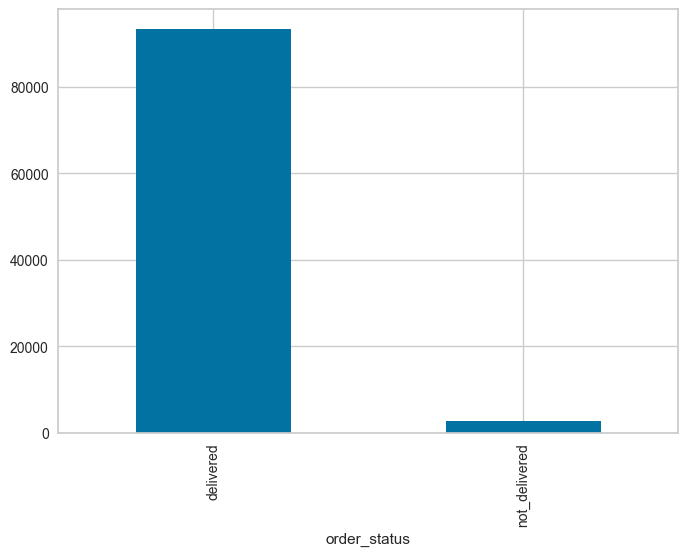

In [57]:
df_g['order_status']=df_g['order_status'].map(lambda x : 'not_delivered' if 'delivered' not in x else x)
display(df_g['order_status'].value_counts().plot(kind = 'bar'))


In [58]:
df_o.drop(columns='index',inplace=True)
df_r.drop(columns='index',inplace=True)
df_i.drop(columns='index',inplace=True)

In [59]:


df_merged1 =       df_o.merge(df_c, on= 'customer_id', how='left')
df_merged2 = df_merged1.merge(df_r, on= 'order_id', how='left')
df_merged3 = df_merged2.merge(df_i, on= 'order_id', how='left')

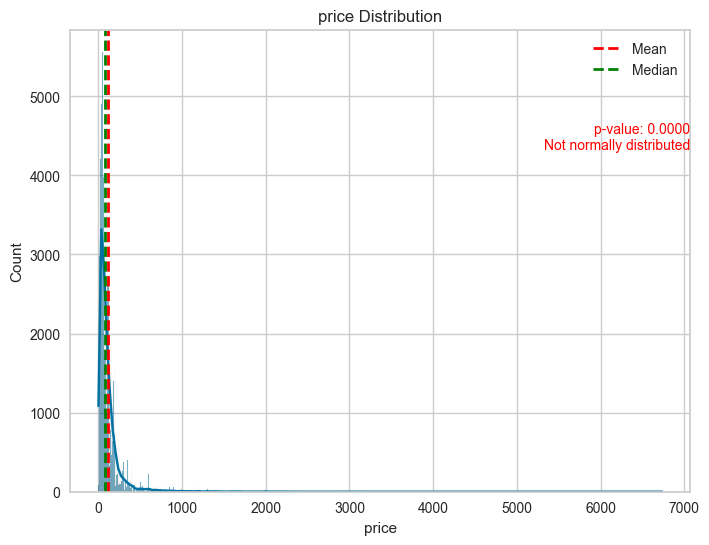

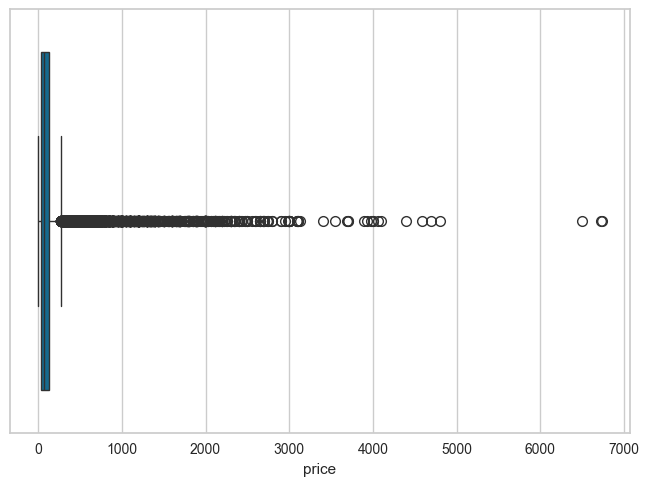

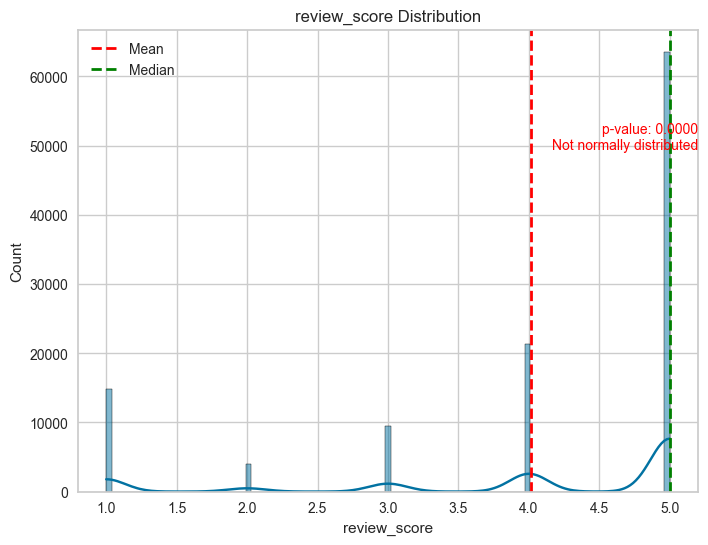

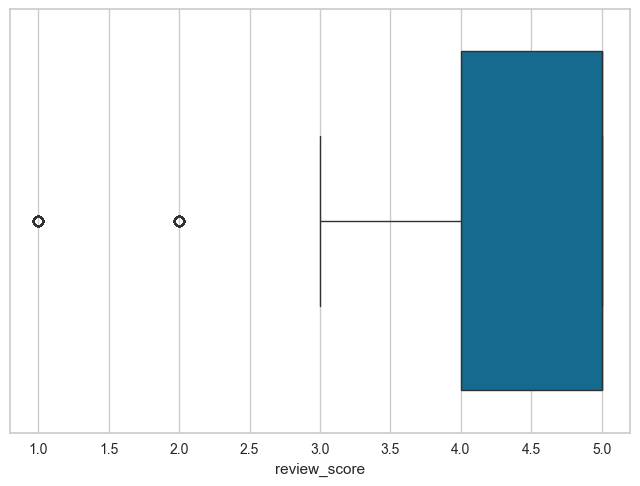

In [60]:
plot_variables(df_merged3[['price','review_score']])

Nous observons que les clients sont majoritairement content (60000). Il existe toutefois une quantité non négligeable (15000) de clients ayant votés 1.

Pour observer le nombre d'achat par client nous allons regrouper les donées par 'customer_unique_id' :

In [61]:
df_merged3['order_purchase_timestamp'] =  pd.to_datetime(df_merged3['order_purchase_timestamp']) 
df_merged3['diff'] =pd.to_datetime('2018-10-17 17:30:18') - df_merged3['order_purchase_timestamp'] 
df_merged3['diff']=df_merged3['diff'].map(lambda x : x.days)

df3_gr = df_merged3.groupby('customer_unique_id', as_index=False, dropna=False).agg( 
    COUNT_sale=('order_purchase_timestamp', 'count'),
    SUM_price=('price', 'sum'),
    last_sale=('diff', 'min'),
    AVG_review_score=('review_score', 'mean')
)

COUNT_sale
1     84075
2      8889
3      1787
4       698
5       285
6       223
7        49
8        24
9        15
10       13
12       12
11       11
14        4
15        3
20        2
24        2
21        1
13        1
17        1
18        1
Name: count, dtype: int64

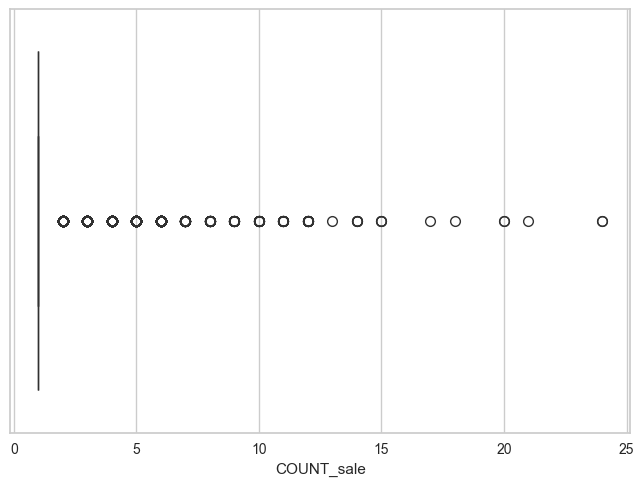

In [62]:
sns.boxplot(df3_gr, x= 'COUNT_sale')
df3_gr['COUNT_sale'].value_counts()

Nous observons qu'une grande majorité des clients n'effectue qu'un achat.

Observons à présent la répartition des commandes par jours :

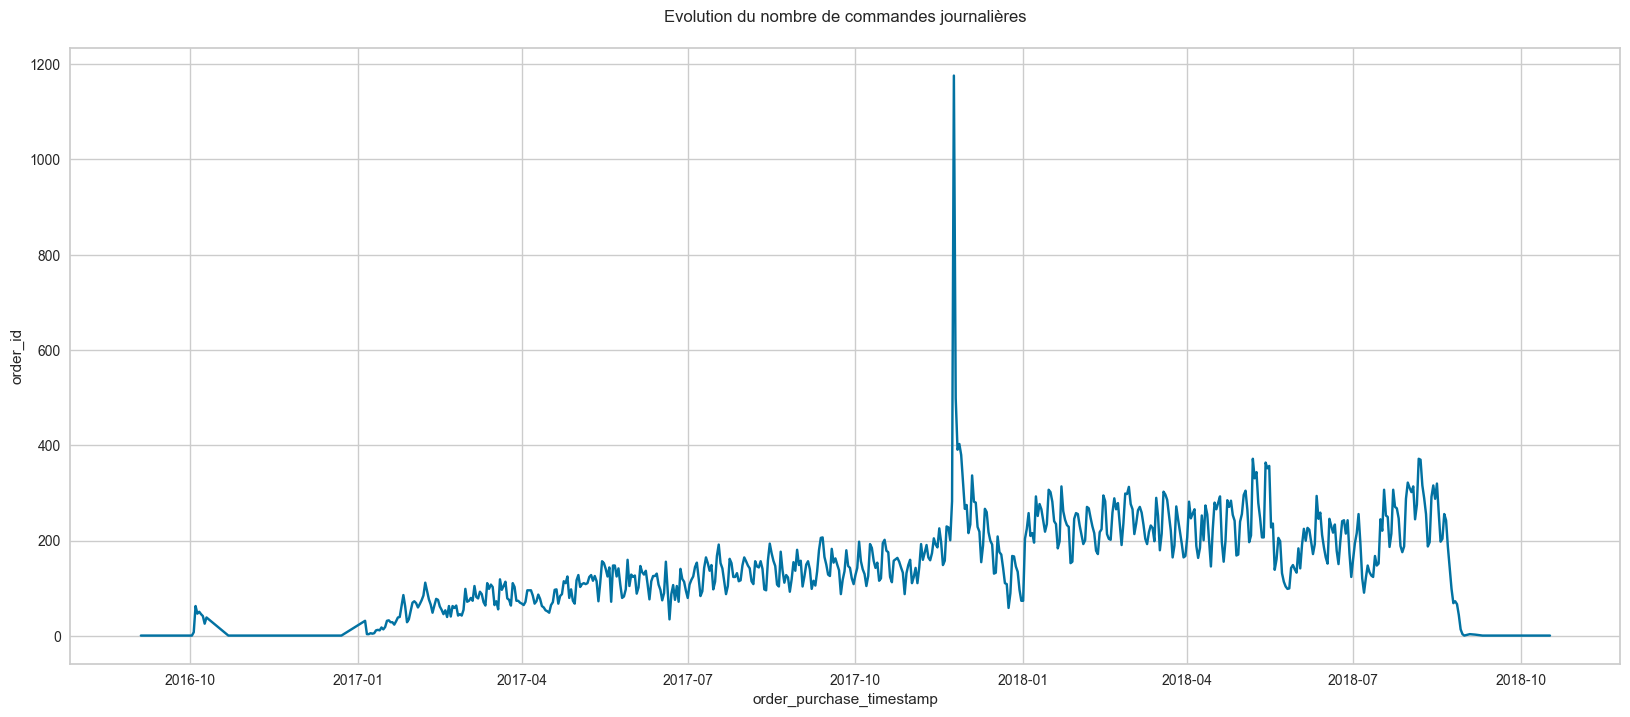

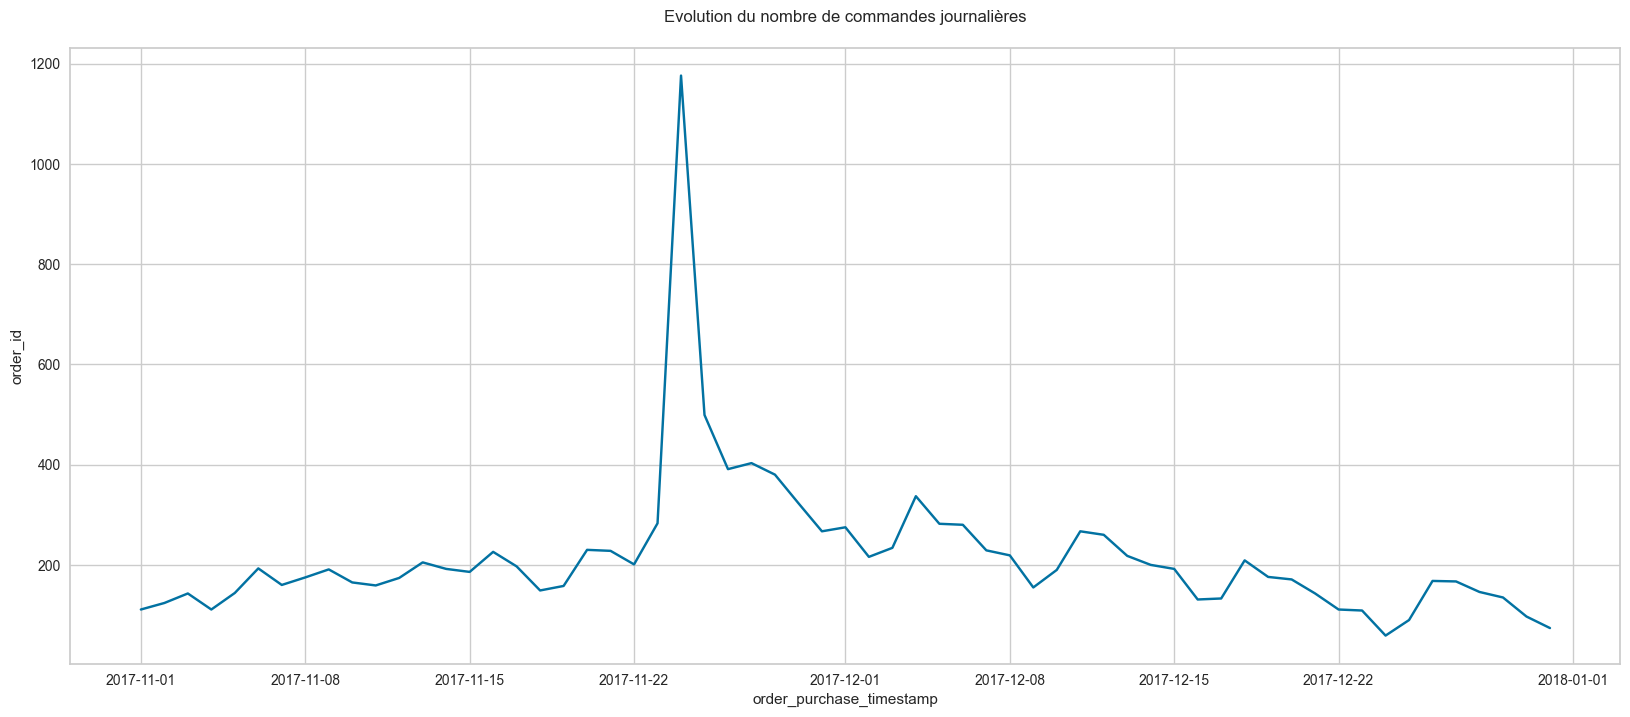

In [63]:
df_o["order_purchase_timestamp"] = df_o["order_purchase_timestamp"].astype('datetime64[ns]')
orders_per_days = df_o.groupby(df_o["order_purchase_timestamp"].dt.date).count()["order_id"]
fig = plt.figure(figsize=(20, 8))
sns.lineplot(orders_per_days)
plt.title(f"Evolution du nombre de commandes journalières\n")
plt.show()

df_zoom = df_o.loc[df_o["order_purchase_timestamp"].between("2017 11 01", "2018 01 01")]
orders_per_days = df_zoom.groupby(df_zoom["order_purchase_timestamp"].dt.date).count()["order_id"]
fig = plt.figure(figsize=(20, 8))
sns.lineplot(orders_per_days)
plt.title(f"Evolution du nombre de commandes journalières\n")
plt.show()


La distribution des ventes journalières est assez hétérogène. Nous observons très peu de ventes entre octobre 2016 et janvier 2017. Ceci vaut aussi pour les ventes d'octobre 2018.

Nous observons également un pic de commande fin novembre, potentiellement lié à des achats de noel.

# Gestion des valeurs manquantes

Visualisons les valeurs manquantes :

In [64]:
bilan_null(df_g)

,Nunique,Missing ratio,Null count,Notnull count
customer_unique_id,96096,0.000000,0,96096
COUNT_sale,20,0.000000,0,96096
first_sale,624,0.000000,0,96096
last_sale,632,0.000000,0,96096
customer_state,27,0.000000,0,96096
order_status,2,0.000000,0,96096
latitude,27,0.000000,0,96096
longitude,27,0.000000,0,96096
AVG_price,8218,0.007035,676,95420
MIN_price,5782,0.007035,676,95420


Les valeurs prix et reviews score ne sont pas toutes remplies. Y a t il un lien de cause a effet ?

In [65]:
df_g[df_g['AVG_price'].isnull()]['AVG_review_score'].mean()

1.614567526555387

In [66]:
df_g[df_g['AVG_price'].notnull()]['AVG_review_score'].mean()



4.1018788628948215

La moyenne des avis sur les clients dont le prix est NaN est de 1.6 alors que la moyenne générale est a 4.1.  

Les features liées aux prix enregistrées comme NaN proviennent de commandes annulées ou présentant un problème. Afin de conserver cette donnée client les valeurs seront mise à 0.  
Les reviews score manquant seront imputés par la médiane.

# Gestion des valeurs abérrantes 
Au vu des résultats du descritpif numériques des csv, il n'y a pas de raison de penser que certaines valeurs soient des outliers. Un client a pu passer 20 commandes, il n'y a pas de note en dehors de l'intervalle 1-5, les dates semblent logiques, la répartition géographique également.

# Gestion des doublons

Observons si le dataset présente des doublons 

In [67]:
inspect_dupes(df_g)

Number of duplicates found: 0


0

In [68]:
inspect_dupes(df_o)

Number of duplicates found: 0


0

In [69]:
inspect_dupes(df_i)

Number of duplicates found: 0


0

In [70]:
inspect_dupes(df_r)

Number of duplicates found: 0


0

In [71]:
df_o.duplicated(subset=('order_id')).sum()

0

Il n'y a pas de doublons dans les datasets